<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 3: Choropleth Mapping</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>
</div>

This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bD/lab_D.html

In this session, we will build on all we have learnt so far about loading and manipulating (spatial) data and apply it to one of the most commonly used forms of spatial analysis: choropleth maps. These are maps that display the spatial distribution of a variable value, based on:
- value **aggegration** with polygons demarcating e.g. regions, municipalities, countries etc.
- classification of polygon values using a **classification scheme**
- visualization of classes using a in color scheme, also called **palette**. 

Although there are many ways in which you can classify and visualize your values, we will focus in this context only on a handful of them:

* Categorical
* Equal interval
* Quantiles
* Fisher-Jenks
* Manual classification

You can get a feel for the different classification schemes here: https://mgimond.github.io/Spatial/symbolizing-features.html#an-interactive-example

In [39]:
import geopandas as gpd 
import pandas as pd
from pysal.lib import examples
import seaborn as sns 
from pysal.viz import mapclassify
import numpy as np
import matplotlib.pyplot as plt 

## Libraries

### PySal

[PySal](https://pysal.org/) is a core library for geospatial analysis. In this course we will both use it for classification, like today, and later for analysis of spatial autocorrelation, etc.

### seaborn

library for statistical data visualization.

## Data

We will use a data set on [Mexico GDP per capita](https://geographicdata.science/book/data/mexico/README.html), which we can access as a PySAL example dataset. You can read more about PySAL example datasets [here](https://pysal.org/libpysal/notebooks/examples.html).

We can get a short explanation of the dataset through the `explain` method:

In [4]:
examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



Now, to download it from its remote location, we can use `load_example`:

In [5]:
mx = examples.load_example("mexico")

This will download the data and place it on your home directory. We can inspect the directory where it is stored:

In [6]:
mx.get_file_list()

['/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/mexicojoin.dbf',
 '/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/mexico.gal',
 '/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/README.md',
 '/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/mexicojoin.shp',
 '/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/mexicojoin.prj',
 '/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/mexico.csv',
 '/opt/conda/lib/python3.9/site-packages/libpysal/examples/mexico/mexicojoin.shx']

For this section, we will read the ESRI shapefile, which we can do by pointing `geopandas.read_file` to the `.shp` file. The utility function `get_path` makes it a bit easier for us:

In [7]:
mex = gpd.read_file(examples.get_path("mexicojoin.shp"))

In [8]:
type(mex)

geopandas.geodataframe.GeoDataFrame

And, from now on, `mex` is a table as we are used to so far in this course:

In [9]:
mex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POLY_ID     32 non-null     int64   
 1   AREA        32 non-null     float64 
 2   CODE        32 non-null     object  
 3   NAME        32 non-null     object  
 4   PERIMETER   32 non-null     float64 
 5   ACRES       32 non-null     float64 
 6   HECTARES    32 non-null     float64 
 7   PCGDP1940   32 non-null     float64 
 8   PCGDP1950   32 non-null     float64 
 9   PCGDP1960   32 non-null     float64 
 10  PCGDP1970   32 non-null     float64 
 11  PCGDP1980   32 non-null     float64 
 12  PCGDP1990   32 non-null     float64 
 13  PCGDP2000   32 non-null     float64 
 14  HANSON03    32 non-null     float64 
 15  HANSON98    32 non-null     float64 
 16  ESQUIVEL99  32 non-null     float64 
 17  INEGI       32 non-null     float64 
 18  INEGI2      32 non-null     float64 
 19  MA

In [10]:
mex.head(3)

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.40,4.47,4.43,4.48,1.0,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,2,7.225988e+10,MX03,Baja California Sur,2912880.772,1.785573e+07,7225987.769,9573.0,16013.0,16707.0,...,0.00,3.98,4.20,4.22,4.39,4.46,4.41,4.42,2.0,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,3,2.731957e+10,MX18,Nayarit,1034770.341,6.750785e+06,2731956.859,4836.0,7515.0,7621.0,...,-0.05,3.68,3.88,3.88,4.04,4.13,4.11,4.06,3.0,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."


The data however does not include a CRS:

In [11]:
mex.crs

To be able to add baselayers, we need to specify one. With a bit of research, we find the data are expressed in longitude and latitude using WGS84, so the CRS we can use is `EPSG:4326`. Let's add it to `mex`:

In [12]:
mex.crs = "EPSG:4326"
mex.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
mex.explore()

Now we are ready to map!

## Choropleths

### Categorical values

A choropleth for categorical variables simply assigns a different color to every potential value in the series. The main requirement in this case is then for the **color scheme** to reflect the fact that different values are **not ordered** or follow a particular scale.

In Python, creating categorical choropleths is possible with one line of code. To demonstrate this, we can plot the Mexican states and the region each belongs to based on the Mexican Statistics Institute (coded in our table as the `INEGI` variable):

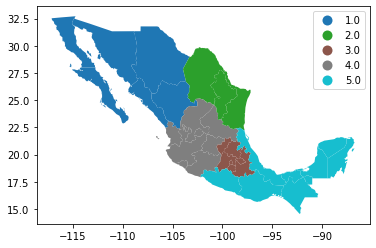

In [14]:
mex.plot(
    column="INEGI", 
    categorical=True, 
    legend=True,
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);

**Let us stop for a second and note a few crucial aspects:**

* Note how we are using the same approach as for basic maps, the command `plot`, but we now need to add the argument `column` to specify which column has the value that we want to map.
* Since the variable is categorical we need to make that explicit by setting the argument `categorical` to `True`.
* As an optional argument, we can set `legend` to `True` and the resulting figure will include a legend with the names of all the values in the map.
* Unless we specify a different colormap, the selected one respects the categorical nature of the data by not implying a gradient or scale but a qualitative structure.

Both [Matplotib](https://matplotlib.org/2.0.2/users/colormaps.html) and [Colorbrewer](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3) have great guides for choosing colormaps.

### Equal interval

If, instead of categorical variables, we want to display the geographical distribution of a continuous phenomenon, we need to select a way to encode each value into a color. One potential solution is applying what is usually called "equal intervals". The intuition of this method is to split the *range* of the distribution, the difference between the minimum and maximum value, into equally large segments and to assign a different color to each of them according to a palette that reflects the fact that values are ordered.

Creating the choropleth is relatively straightforward in Python. For example, to create an equal interval on the GDP per capita in 2000 (`PCGDP2000`), we can run a similar command as above:

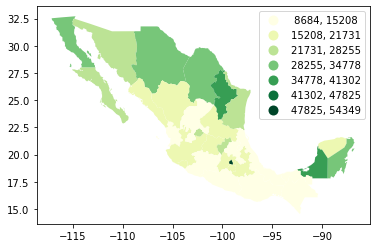

In [15]:
mex.plot(
    column="PCGDP2000", 
    scheme="equal_interval", 
    k=7,
    cmap="YlGn",
    legend=True,
    legend_kwds={"fmt": "{:.0f}"},  # Remove decimals in legend
);

**Pay attention to the key differences:**

* Instead of specifyig `categorical` as `True`, we replace it by the argument `scheme`, which we will use for all choropleths that require a continuous classification scheme. In this case, we set it to `equal_interval`.
* As above, we set the number of colors to 7. 
* As optional arguments, we can change the colormap to a yellow to green gradient, which is one of the recommended ones by [ColorBrewer](http://colorbrewer2.org/) for a sequential palette. 

Now, let's dig a bit deeper into the classification, and how exactly we are encoding values into colors. Each segment, also called bins or buckets, can also be calculated using the library `mapclassify` from the `PySAL` family:

In [16]:
eq = mapclassify.EqualInterval(mex["PCGDP2000"], k=7)
eq

EqualInterval               

      Interval         Count
----------------------------
[ 8684.00, 15207.57] |    10
(15207.57, 21731.14] |    10
(21731.14, 28254.71] |     5
(28254.71, 34778.29] |     4
(34778.29, 41301.86] |     2
(41301.86, 47825.43] |     0
(47825.43, 54349.00] |     1

The only additional argument to pass to `Equal_Interval`, other than the actual variable we would like to classify is the number of segments we want to create, `k`, which we are arbitrarily setting to 7 in this case. This will be the number of colors that will be plotted on the map. Although having several can give more detail, at some point the marginal value of an additional one is fairly limited, given the ability of the brain to tell any differences.

Once we have classified the variable, we can check the actual break points where values stop being in one class and become part of the next one:

In [17]:
eq.bins

array([15207.57142857, 21731.14285714, 28254.71428571, 34778.28571429,
       41301.85714286, 47825.42857143, 54349.        ])

The array of breaking points above implies that any value in the variable below 15,207.57 will get the first color in the gradient when mapped, values between 15,207.57 and 21,731.14 the next one, and so on.

The key characteristic in equal interval maps is that the bins are allocated based on the magnitude on the values, irrespective of how many obervations fall into each bin as a result of it. In highly skewed distributions, this can result in bins with a large number of observations, while others only have a handful of outliers. This can be seen in the summary table printed out above, where ten states are in the first group, but only one state belong to the one with highest values, and zero states are in the second highest class. This distribution of values in the classes can be represented visually with a kernel density plot where the break points are included as well:

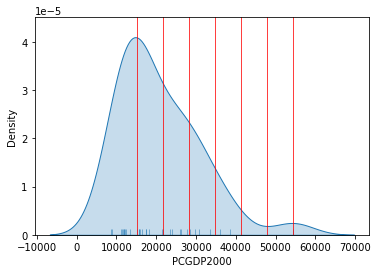

In [18]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(mex["PCGDP2000"], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(mex["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in eq.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

Technically speaking, the figure is created by overlaying a KDE plot with vertical bars for each of the break points. This makes much more explicit the issue highlighed by which the first bin contains a large amount of observations while the one with top values only encompasses a handful of them.

We can also explore the distribution of values with a traditional histogram:

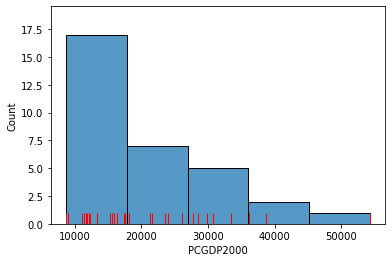

In [19]:
# Plot histogram
ax = sns.histplot(mex["PCGDP2000"], bins=5)
# Add rug on horizontal axis
sns.rugplot(mex["PCGDP2000"], height=0.05, color="red", ax=ax);

We can see that the data are highly skewed, which means that an equal interval classification is not the best choice.

### Quantiles

One solution to obtain a more balanced classification scheme is using quantiles. This, by definition, assigns the same amount of values to each bin: the entire series is laid out in order and break points are assigned in a way that leaves exactly the same amount of observations between each of them. This "observation-based" approach contrasts with the "value-based" method of equal intervals and, although it can obscure the magnitude of extreme values, it can be more informative in cases with skewed distributions.

The code required to create the choropleth mirrors that needed above for equal intervals:

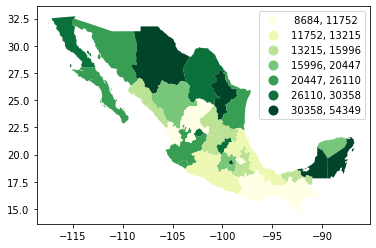

In [20]:
mex.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=True,
    legend_kwds={"fmt": "{:.0f}"}
);

Note how, in this case, the amount of polygons in each color is by definition much more balanced (almost equal in fact, except for rounding differences). This obscures outlier values, which get blurred by significantly smaller values in the same group, but allows to get more detail in the "most populated" part of the distribution, where instead of only white polygons, we can now discern more variability.

To get further insight into the quantile classification, let's calculate it with `mapclassify`:

In [21]:
quant7 = mapclassify.Quantiles(mex["PCGDP2000"], k=7)
quant7

Quantiles                   

      Interval         Count
----------------------------
[ 8684.00, 11752.00] |     5
(11752.00, 13215.43] |     4
(13215.43, 15996.29] |     5
(15996.29, 20447.14] |     4
(20447.14, 26109.57] |     5
(26109.57, 30357.86] |     4
(30357.86, 54349.00] |     5

And, similarly, the bins can also be inspected:

In [22]:
quant7.bins

array([11752.        , 13215.42857143, 15996.28571429, 20447.14285714,
       26109.57142857, 30357.85714286, 54349.        ])

The visualization of the distribution can be generated in a similar way as well:

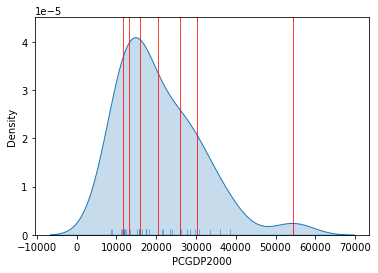

In [23]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(mex["PCGDP2000"], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(mex["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in quant7.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

The KDE plot makes it clear that the better distribution of values in different classes come at the expense of highly uneven class ranges.

### Fisher-Jenks

Equal interval and quantiles are only two examples of very many classification schemes to encode values into colors. Although not all of them are integrated into `GeoPandas`, `PySAL` includes several other classification schemes (for a detailed list, have a look at [mapclassify examples](https://pysal.org/mapclassify/notebooks/01_maximum_breaks.html) or [mapclassify documentation](https://pypi.org/project/mapclassify/)). As an example of a more sophisticated one, let us create a Fisher-Jenks choropleth:

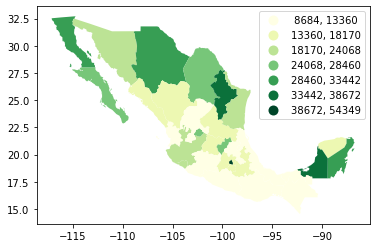

In [24]:
mex.plot(
    column="PCGDP2000", 
    scheme="fisher_jenks", 
    k=7,
    cmap="YlGn",
    legend=True,
    legend_kwds={"fmt": "{:.0f}"}, 
);

In [25]:
mapclassify.FisherJenks?

Init signature: mapclassify.FisherJenks(y, k=5)
Docstring:     
Fisher Jenks optimal classifier - mean based

Parameters
----------
y : array
    (n,1), values to classify
k : int
    number of classes required

Attributes
----------
yb      : array
          (n,1), bin ids for observations
bins    : array
          (k,1), the upper bounds of each class
k       : int
          the number of classes
counts  : array
          (k,1), the number of observations falling in each class

Examples
--------
>>> import mapclassify as mc
>>> cal = mc.load_example()
>>> fj = mc.FisherJenks(cal)
>>> fj.adcm
799.24
>>> fj.bins
array([  75.29,  192.05,  370.5 ,  722.85, 4111.45])
>>> fj.counts
array([49,  3,  4,  1,  1])
>>>
File:           /opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py
Type:           type
Subclasses:     


The same classification can be obtained with a similar approach as before:

In [26]:
fjenks = mapclassify.FisherJenks(mex["PCGDP2000"], k=7)
fjenks

FisherJenks                 

      Interval         Count
----------------------------
[ 8684.00, 13360.00] |    10
(13360.00, 18170.00] |     8
(18170.00, 24068.00] |     4
(24068.00, 28460.00] |     4
(28460.00, 33442.00] |     3
(33442.00, 38672.00] |     2
(38672.00, 54349.00] |     1

This methodology aims at minimizing the variance *within* each bin while maximizing that *between* different classes.

In [27]:
fjenks.bins

array([13360., 18170., 24068., 28460., 33442., 38672., 54349.])

Graphically, we can see how the break points are not equally spaced but are adapting to obtain an optimal grouping of observations:

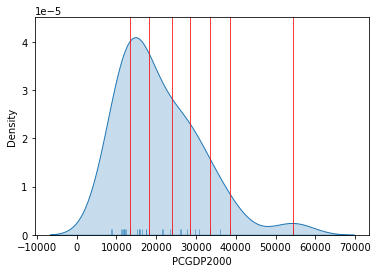

In [28]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(mex["PCGDP2000"], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(mex["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in fjenks.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

For example, the bin with highest values covers a much wider span that the one with lowest, because there are fewer states in that value range.

### Manual classification

Finally, we can make our own manual classification. This is mostly relevant if there are pre-defined values or classes for the mapped value. For example, official definitions of when a state has a low or high per capita income.

To demonstrate, we will just use the median and mean values to create 3 different manual classes:

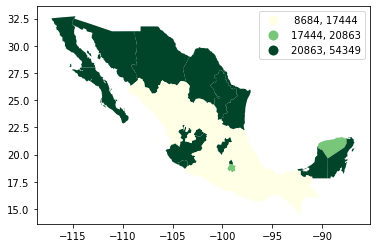

In [29]:
bins = [17444,20863]

mex.plot(
    column="PCGDP2000", 
    scheme="user_defined", # choose 'user_defined'
    classification_kwds={'bins':bins}, # provide the bins
    cmap="YlGn",
    legend=True,
    legend_kwds={"fmt": "{:.0f}"},
);

A closer inspection of the distribution of values shows us that only two states have a per capita income between the median and the mean:

In [30]:
userdef = mapclassify.UserDefined(mex["PCGDP2000"], bins)
userdef

UserDefined                 

      Interval         Count
----------------------------
[ 8684.00, 17444.00] |    16
(17444.00, 20863.00] |     2
(20863.00, 54349.00] |    14

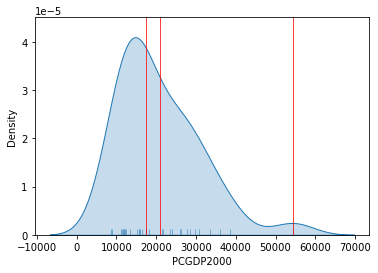

In [31]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(mex["PCGDP2000"], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(mex["PCGDP2000"], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in userdef.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

## Zooming

### Zoom into full map

A general map of an entire region, or urban area, can sometimes obscure local patterns because they happen at a much smaller scale that cannot be perceived in the global view. One way to solve this is by providing a focus of a smaller part of the map in a separate figure. Although there are many ways to do this in Python, the most straightforward one is to reset the limits of the axes to center them in the area of interest.

As an example, let us consider the quantile map produced above:

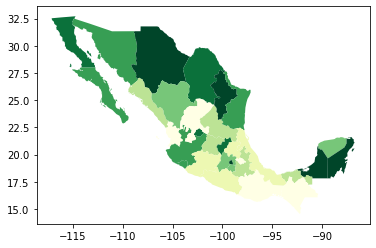

In [32]:
mex.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False
);

If we want to focus around the capital, Mexico DF, the first step involves realising that such area of the map (the little dark green polygon in the SE centre of the map), falls within the coordinates of -102W/-97W, and 18N/21N, roughly speaking. To display a zoom map into that area, we can do as follows:

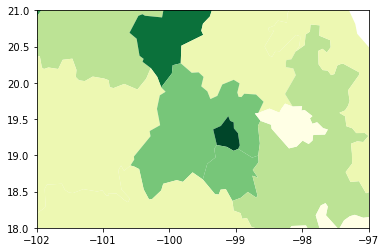

In [33]:
# Setup the figure
f, ax = plt.subplots(1)
# Draw the choropleth
mex.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False,
    ax=ax
)
# Redimensionate X and Y axes to desired bounds
ax.set_ylim(18, 21)
ax.set_xlim(-102, -97);

### Partial map

The approach above is straightforward, but not necessarily the most efficient one: note that, to generate a map of a potentially very small area, we effectively draw the entire (potentially very large) map, and discard everything except the section we want. This is not straightforward to notice at first sight, but what Python is doing in the code cell above is plottin the entire `mex` object, and only then focusing the figure on the X and Y ranges specified in `set_xlim`/`set_ylim`.

Sometimes, this is required. For example, if we want to retain the same coloring used for the national map, but focus on the region around Mexico DF, this approach is the easiest one.

However, sometimes, we only need to plot the _geographical features_ within a given range, and we either don't need to keep the national coloring (e.g. we are using a single color), or we want a classification performed _only_ with the features in the region.

For these cases, it is computationally more efficient to select the data we want to plot first, and then display them through `plot`. For this, we can rely on the `cx` operator (coordinate based indexing): https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html

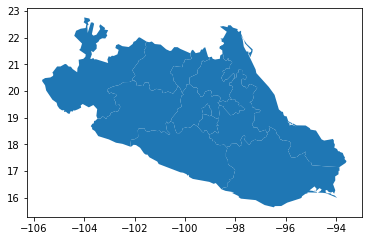

In [34]:
subset = mex.cx[-102:-97, 18:21]
subset.plot();

We query the range of spatial coordinates similarly to how we query indices with `loc`. Note however the result includes full geographic features, and hence the polygons with at least some area within the range are included fully. This results in a larger range than originally specified.

This approach is a "spatial slice", where instead of subsetting by indices of the table, slices are based on the spatial coordinates of the data represented in the table.

Since the result is a `GeoDataFrame` itself, we can create a choropleth that is based only on the data in the subset:

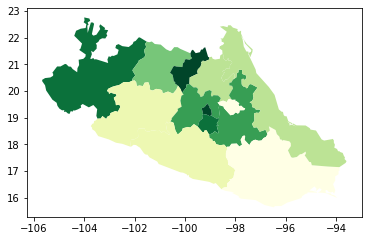

In [35]:
subset.plot(
    column="PCGDP2000", 
    scheme="quantiles", 
    k=7,
    cmap="YlGn",
    legend=False
);

## Advanced: Inspection of classification schemes

As a special case of clustering, the definition of the number of classes and the class boundaries pose a problem to the map designer. We want to find the 'optimal' class bins, but the optimal depends on the purpuse with the analysis/map!

Relevant considerations for the "optimal" classfication scheme is both it's ability to show the true distribution of values, comprehensibility, but also the spatial distribution of the attribute values and the ability of the classifier to convey a sense of that spatial distribution. As you will see later on, this is not necessarily directly related to the statistical distribution of the attribute values. We will return to a joint consideration of both the statistical and spatial distribution of the attribute values in comparison of classifiers below.

For map classification, a common optimality criterion is a measure of fit. In mapclassify, the “**absolute deviation around class medians” (ADCM)** is calculated and provides a measure of fit that allows for comparison of alternative classifiers for the same value of . The ADCM will give us a sense of how “compact” each group is. To see this, we can compare different classifiers for  on the Mexico data:

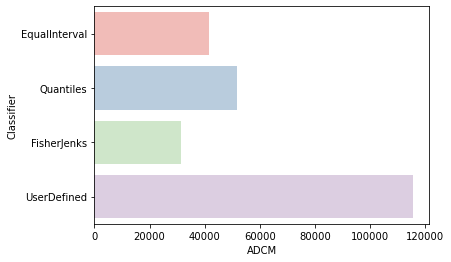

In [36]:
# Bunch classifier objects
classifiers = eq, quant7, fjenks, userdef
# Collect ADCM for each classifier
fits = np.array([c.adcm for c in classifiers])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms["classifier"] = [c.name for c in classifiers]
# Add column names to the ADCM
adcms.columns = ["ADCM", "Classifier"]
ax = sns.barplot(
    y="Classifier", x="ADCM", data=adcms, palette="Pastel1"
)

We can see that our user defined classification is not performing very well. Fisher-Jenks has the best fit (lower is better!), which is not surprising - but equal interval is not too far of.
Depending on the audience, an equal interval classification might be the best choice.

The ADCM provides a global measure of fit which can be used to compare the alternative classifiers. As a complement to this global perspective, it can be revealing to consider how each of the observations in our data was classified across the alternative approaches. To do this we can add the class bin attribute (yb) generated by the mapclassify classifiers as additional columns in the dataframe to visualise how they map to observations:

In [37]:
# Append class values as a separate column
mex["Equal Interval"] = eq.yb
mex["Quantiles"] = quant7.yb
mex["Fisher-Jenks"] = fjenks.yb
mex["User Defined"] = userdef.yb

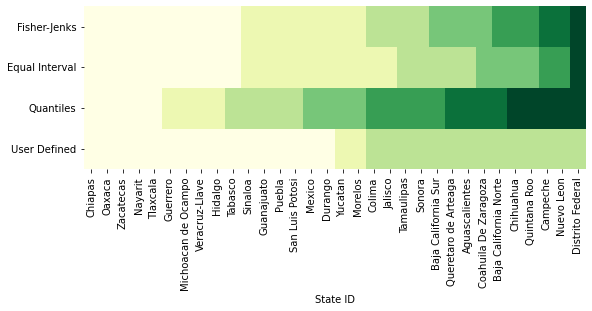

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 3))
sns.heatmap(
    mex.set_index("NAME")
    .sort_values("PCGDP2000")[
        [
            "Fisher-Jenks",
            "Equal Interval",
            "Quantiles",
            "User Defined"
        ]
    ]
    .T,
    cmap="YlGn",
    cbar=False,
    ax=ax,
)
ax.set_xlabel("State ID");